"파이썬 딥러닝 텐서플로우" 교재 중  
"part 04 합성곱 신경망(CNN) 04 위성 이미지 분류"에 대한 코드 정리

In [1]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pylab as plt

# tensorflow dataset 활용
import tensorflow_datasets as tfds

json 라이브러리가 무엇인지 궁금하면 아래 글을 참고하자.  
[json 라이브러리에 대한 설명](http://pythonstudy.xyz/python/article/205-JSON-%EB%8D%B0%EC%9D%B4%ED%83%80)  
사람과 기계가 쉽게 읽을 수 있는 데이터 포맷 중 하나라고 한다.

`ModuleNotFoundError: No module named 'tensorflow_datasets'`  
에러가 나타나면 아나콘다 내비게이터를 실행해서, tensorflow_datasets' 패키지를 설치해주자.  
근데 난 이걸로 해결 안됐음  
왜그런건지 모르겠는데 주피터노트북 커널 연결이 안되고 계속 연결 실패 오류 뜨길래 vsc로 와서 작업하니 된다 아놔

In [4]:
DATA_DIR = "dataset/"

(train_ds, valid_ds),info = tfds.load('eurosat/rgb', split=['train[:80%]', 'train[80%:]'],
                                     shuffle_files=True,
                                     as_supervised=True,
                                     with_info=True,
                                     data_dir=DATA_DIR)

print(train_ds)
print(valid_ds)

Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...: 100%|██████████| 1/1 [00:08<00:00,  8.26s/ url]

Dl Completed...: 100%|██████████| 1/1 [00:28<00:00, 28.74s/ url]


Dataset eurosat downloaded and prepared to dataset/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
<_OptionsDataset shapes: ((64, 64, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((64, 64, 3), ()), types: (tf.uint8, tf.int64)>


In [5]:
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_path='dataset/eurosat/rgb/2.0.0',
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disa

2022-02-19 06:59:17.978440: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-19 06:59:18.064550: W tensorflow/core/kernels/data/cache_dataset_ops.cc:757] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


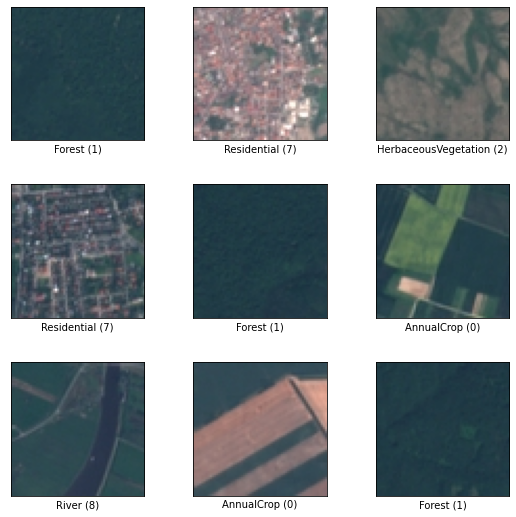

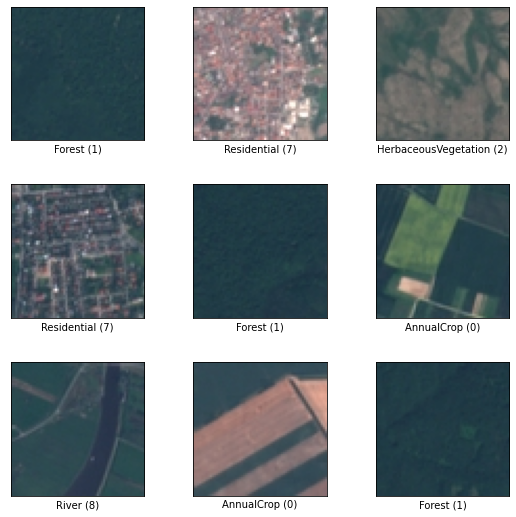

In [6]:
tfds.show_examples(train_ds, info)

2022-02-19 07:00:14.693178: W tensorflow/core/kernels/data/cache_dataset_ops.cc:757] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


,image,label
0,,5 (Pasture)
1,,7 (Residential)
2,,0 (AnnualCrop)
3,,1 (Forest)
4,,0 (AnnualCrop)
5,,2 (HerbaceousVegetation)
6,,9 (SeaLake)
7,,8 (River)
8,,2 (HerbaceousVegetation)
9,,9 (SeaLake)

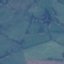
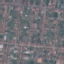
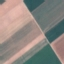
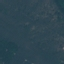
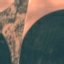
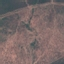
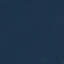
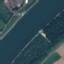
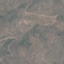
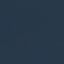

In [8]:
#as_dataframe 사용해서 샘플 출력
tfds.as_dataframe(valid_ds.take(10), info)

In [9]:
NUM_CLASSES = info.features["label"].num_classes
print(NUM_CLASSES)

10


In [10]:
#숫자 레이블을 활용해 문제열 메타 데이터로 변환한다.
#클래스 6 : 영구작물(Permanent Crop)을 의미
print(info.features["label"].int2str(6))

PermanentCrop


2. 데이터 전처리

In [13]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

def preprocess_data(image, label) :
    image = tf.cast(image, tf.float32) / 255.
    return image, label

train_data = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_data = valid_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

3. 모델 훈련 및 검증

In [17]:
def build_model():
    
    model = tf.keras.Sequential([
        #convolution 층
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        #classifier 출력층
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
    ])
    
    return model

model = build_model()

In [18]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, validation_data=valid_data, epochs=50)

Epoch 1/50
338/338 [==============================] - 68s 199ms/step - loss: 1.9094 - accuracy: 0.3658 - val_loss: 1.6922 - val_accuracy: 0.4156
Epoch 2/50
338/338 [==============================] - 67s 197ms/step - loss: 1.3109 - accuracy: 0.5321 - val_loss: 0.7993 - val_accuracy: 0.7354
Epoch 3/50
338/338 [==============================] - 67s 197ms/step - loss: 1.0648 - accuracy: 0.6261 - val_loss: 0.7638 - val_accuracy: 0.7609
Epoch 4/50
338/338 [==============================] - 64s 189ms/step - loss: 0.9601 - accuracy: 0.6652 - val_loss: 0.9599 - val_accuracy: 0.6630
Epoch 5/50
338/338 [==============================] - 62s 184ms/step - loss: 0.8706 - accuracy: 0.6965 - val_loss: 0.6078 - val_accuracy: 0.7937
Epoch 6/50
338/338 [==============================] - 61s 181ms/step - loss: 0.7926 - accuracy: 0.7249 - val_loss: 0.5996 - val_accuracy: 0.8131
Epoch 7/50
338/338 [==============================] - 65s 192ms/step - loss: 0.7320 - accuracy: 0.7519 - val_loss: 0.5648 - val_ac

In [24]:
def plot_loss_acc(history, epoch) :
    
    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    axes[0].plot(range(1, epoch + 1), loss, label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')
    
    axes[1].plot(range(1, epoch + 1), acc, label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')
    
    plt.show()
    

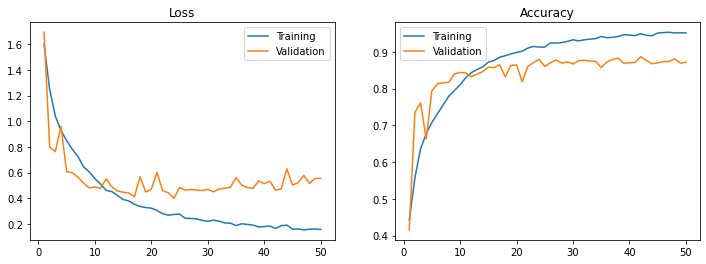

In [25]:
#손실함수, 정확도 그래프
plot_loss_acc(history, 50)

4. 데이터 증강

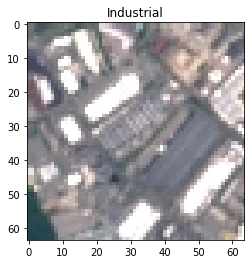

In [26]:
image_batch, label_batch = next(iter(train_data.take(1)))

image = image_batch[0]
label = label_batch[0].numpy()

plt.imshow(image)
plt.title(info.features["label"].int2str(label));

데이터 증강 기법에 사용할 수 있는 여러 예제들

In [27]:
#이미지 변화 전 후를 확인할 수 있는 시각화 함수를 정의한다.
def plot_augmentation(original, augmented):
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    axes[0].imshow(original)
    axes[0].set_title('Original')
    
    axes[1].imshow(augmented)
    axes[1].set_title('Augmented')
    
    plt.show()

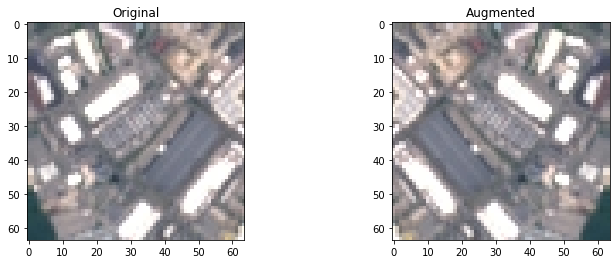

In [28]:
#좌우 뒤집기
lr_flip = tf.image.flip_left_right(image)
plot_augmentation(image, lr_flip)

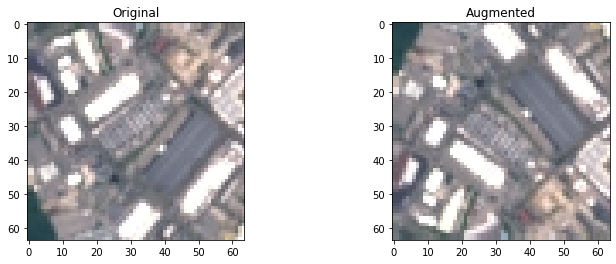

In [29]:
#상하 뒤집기
up_flip = tf.image.flip_up_down(image)
plot_augmentation(image, up_flip)

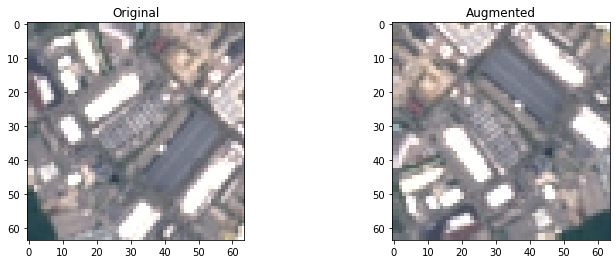

In [30]:
#반시계 방향 90도
rotate90 = tf.image.rot90(image)
plot_augmentation(image, rotate90)

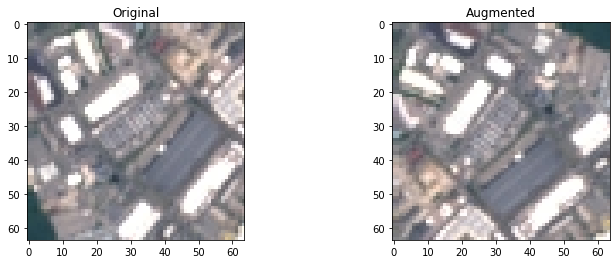

In [31]:
# transposing image
transpose = tf.image.transpose(image)
plot_augmentation(image, transpose)

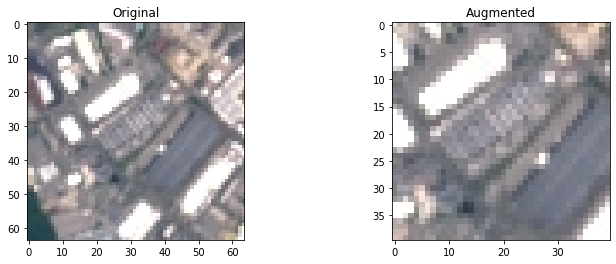

In [32]:
#central crop : 이미지 중심에서 일정 부분 잘라내기
crop1 = tf.image.central_crop(image, central_fraction=0.6)
plot_augmentation(image, crop1)

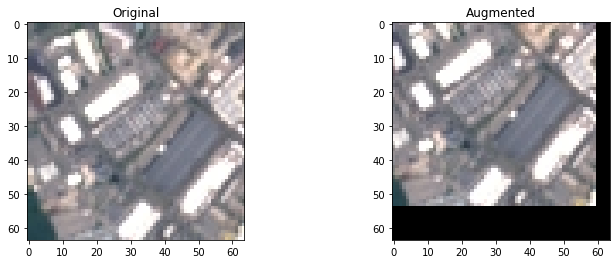

In [33]:
#resize with crop or pad : 원본 이미지 크기 키우기
#random crop : 랜덤한 방향으로 이동
img = tf.image.resize_with_crop_or_pad(image, 64+20, 64+20)
crop2 = tf.image.random_crop(img, size = [64, 64, 3])
plot_augmentation(image, crop2)

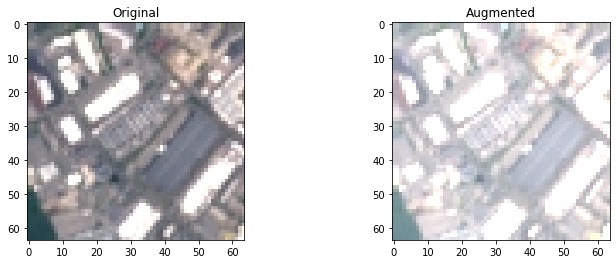

In [34]:
# 이미지 밝기 조정
brightness = tf.image.adjust_brightness(image, delta=0.3)
plot_augmentation(image, brightness)

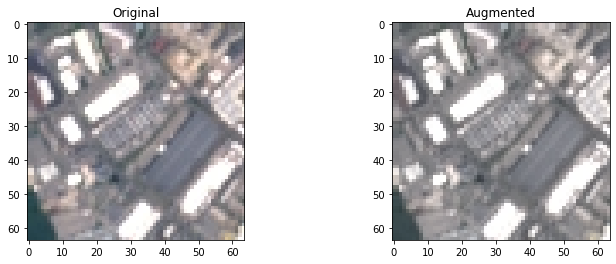

In [35]:
#이미지 채도 조정
saturation = tf.image.adjust_saturation(image, saturation_factor=0.5)
plot_augmentation(image, saturation)

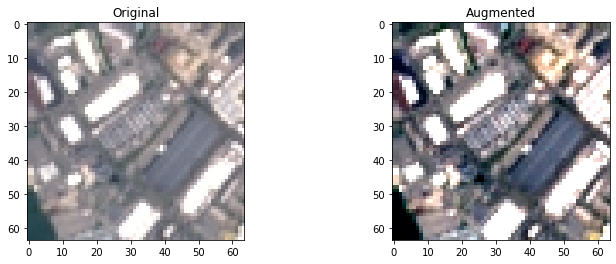

In [36]:
#이미지 대비 조정
contrast = tf.image.adjust_contrast(image, contrast_factor=2)
plot_augmentation(image, contrast)

데이터 증강 및 전처리를 수행하는 사용자 함수 정의 : data_augmentation

In [38]:
def data_augmentation(image, label):

    image=tf.image.random_flip_left_right(image)
    image=tf.image.random_flip_up_down(image)
    image=tf.image.random_brightness(image, max_delta=0.3)
    image=tf.image.random_crop(image, size=[64, 64, 3])
    
    image=tf.cast(image, tf.float32)/255. #0~1 정규화
    
    return image, label

train_aug = train_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug = valid_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_aug = valid_aug.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

print(train_aug)
print(valid_aug)

<PrefetchDataset shapes: ((None, 64, 64, 3), (None,)), types: (tf.float32, tf.int64)>
<PrefetchDataset shapes: ((None, 64, 64, 3), (None,)), types: (tf.float32, tf.int64)>


In [39]:
aug_model = build_model()

aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
aug_history = aug_model.fit(train_aug, validation_data=valid_aug, epochs=50)

Epoch 1/50
338/338 [==============================] - 63s 185ms/step - loss: 2.2232 - accuracy: 0.2429 - val_loss: 1.7198 - val_accuracy: 0.4331
Epoch 2/50
338/338 [==============================] - 61s 179ms/step - loss: 1.6307 - accuracy: 0.3721 - val_loss: 1.2877 - val_accuracy: 0.5328
Epoch 3/50
338/338 [==============================] - 61s 179ms/step - loss: 1.4204 - accuracy: 0.4609 - val_loss: 1.0908 - val_accuracy: 0.6111
Epoch 4/50
338/338 [==============================] - 56s 167ms/step - loss: 1.2747 - accuracy: 0.5161 - val_loss: 1.0704 - val_accuracy: 0.6111
Epoch 5/50
338/338 [==============================] - 56s 165ms/step - loss: 1.1892 - accuracy: 0.5596 - val_loss: 0.9832 - val_accuracy: 0.6711
Epoch 6/50
338/338 [==============================] - 55s 163ms/step - loss: 1.1148 - accuracy: 0.5878 - val_loss: 0.9730 - val_accuracy: 0.6630
Epoch 7/50
338/338 [==============================] - 57s 169ms/step - loss: 1.0375 - accuracy: 0.6264 - val_loss: 0.8651 - val_ac

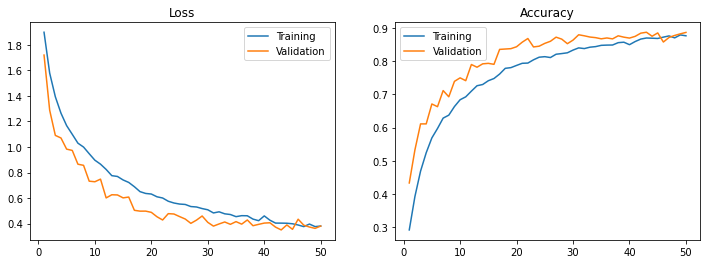

In [41]:
#손실함수, 정확도 그래프
plot_loss_acc(aug_history, 50)